## Подготовка

In [1]:
import pandas as pd

from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import numpy as np

In [3]:
RANDOM_STATE = 123

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
if data.index.is_monotonic:
    print('Данные расположены в хронологическом порядке')
else:
    print('Хронология нарушена')

Данные расположены в хронологическом порядке


In [8]:
data = data.resample('1H').sum()

## Анализ

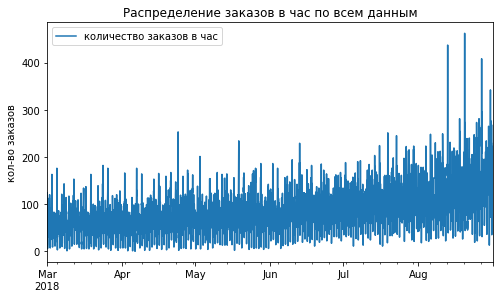

In [9]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
data.plot(ax=plt.gca())
plt.title('Распределение заказов в час по всем данным')
plt.xlabel('')
plt.ylabel('кол-во заказов')
plt.legend(['количество заказов в час'])
plt.show()

Построим графики тренда, сезонности и остатков.

In [10]:
decomposed = seasonal_decompose(data)

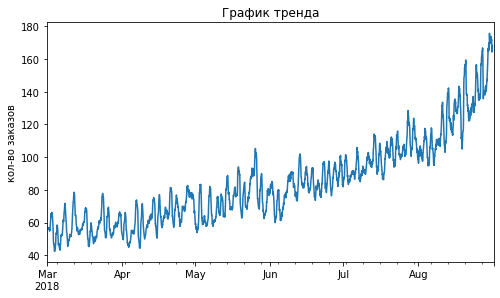

In [11]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('График тренда')
plt.xlabel('')
plt.ylabel('кол-во заказов')
plt.show()

Линия тренда имеет шумы, но наблюдается рост в количестве заказов. В первой декаде июня количество заказов снижалось.

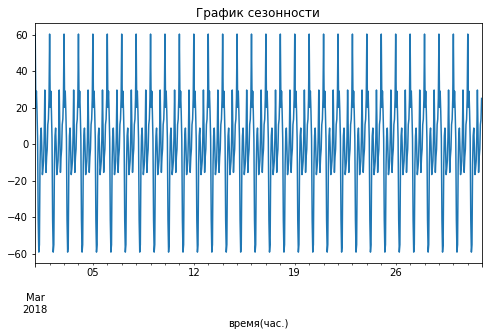

In [12]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('График сезонности')
plt.xlabel('время(час.)')
plt.ylabel('')
plt.show()

График сезонности похож на статционарный. Нужно увеличить масштаб, чтобы увидеть закономерность.

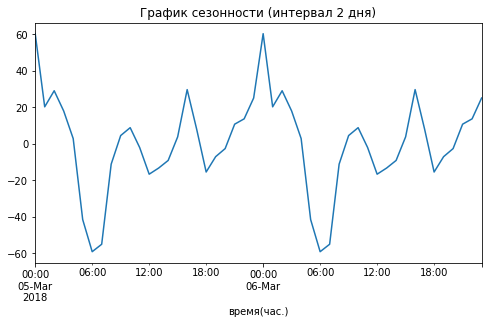

In [13]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.seasonal['2018-03-05':'2018-03-06'].plot(ax=plt.gca())
plt.title('График сезонности (интервал 2 дня)')
plt.xlabel('время(час.)')
plt.ylabel('')
plt.show()

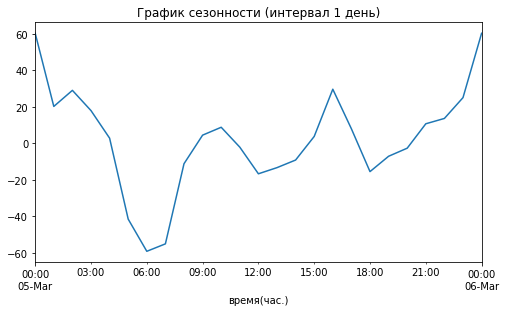

In [14]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.seasonal['2018-03-05':'2018-03-06 00'].plot(ax=plt.gca())
plt.title('График сезонности (интервал 1 день)')
plt.xlabel('время(час.)')
plt.ylabel('')
plt.show()

Больше всего заказов с полуночи до 2 часов, в 10 и 16 часов. В 6 часов заказов меньше всего.

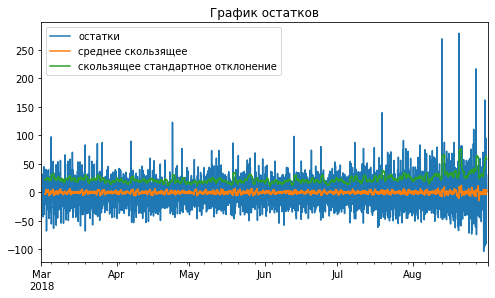

In [15]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
decomposed.resid.plot(ax=plt.gca())
decomposed.resid.rolling(25).mean().plot(ax=plt.gca())
decomposed.resid.rolling(25).std().plot(ax=plt.gca())
plt.title('График остатков')
plt.xlabel('')
plt.ylabel('')
plt.legend(['остатки', 'среднее скользящее', 'скользящее стандартное отклонение'])
plt.show()

В августе наблюдаются высокие значения количества заказов, которые влияют на скользящие среднее и стандартное отклонение, а в конце месяца низкие значения.

## Обучение

In [16]:
# Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    
    # Создаём копию исходной таблицы, так как будет перебор признаков и каждый раз будет обращение
    # к исходному датасету.
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # Убираем пропуски
    df = df.dropna()
    
    # Выделяем признаки и целевой признак
    features = df.drop('num_orders', axis=1)
    target = df['num_orders']
    
    # Делим данные на обучающую, валидационную и тестовую выборки в соотношении 8:1:1 
    features_train, features_valid, \
    target_train, target_valid = train_test_split(features, target, \
                                                  train_size=.8, \
                                                  random_state=RANDOM_STATE, \
                                                  shuffle=False)
    features_valid, features_test, \
    target_valid, target_test = train_test_split(features_valid, target_valid, \
                                                 test_size=.5, \
                                                 random_state=RANDOM_STATE, \
                                                 shuffle=False)
    return(features_train, features_valid, features_test, \
           target_train, target_valid, target_test)

Обучим модель линейной регрессии.

In [17]:
%%time
# Введём условное значение метрики RMSE от которого будет измеряться качество модели
score = 100
for max_lag in range(31, 51):
    for rolling_mean_size in range(1, 11):
        features_train, features_valid, features_test, \
        target_train, target_valid, target_test = make_features(data, \
                                                                max_lag, \
                                                                rolling_mean_size)
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions) ** .5
        if rmse < score:
            best_rmse = rmse
            best_max_lag = max_lag
            best_rolling_mean_size= rolling_mean_size
            model_lr = model
            features_test_lr = features_test
            target_test_lr = target_test
print(f'''
Метрика RMSE у модели линейной регрессии равна {best_rmse} при
количестве столбцов с отстающими значениями = {best_max_lag},
величине окна скользящего среднего = {rolling_mean_size}
''')


Метрика RMSE у модели линейной регрессии равна 31.82081292386252 при
количестве столбцов с отстающими значениями = 50,
величине окна скользящего среднего = 10

CPU times: user 20.2 s, sys: 33.3 s, total: 53.5 s
Wall time: 53.6 s


Обучим модель случайный лес.

In [18]:
%%time
# Введём условное значение метрики RMSE от которого будет измеряться качество модели
score = 100
for max_lag in range(1, 7):
    for rolling_mean_size in range(1, 5):
        features_train, features_valid, features_test, \
        target_train, target_valid, target_test = make_features(data, \
                                                                max_lag, \
                                                                rolling_mean_size)
        for n_estimators in range(5, 31, 5):
            for max_depth in range(1, 30, 3):
                model = RandomForestRegressor(n_estimators=n_estimators, \
                                              max_depth=max_depth, \
                                              random_state=RANDOM_STATE, \
                                              n_jobs=-1)
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                rmse = mean_squared_error(target_valid, predictions) ** .5
                if rmse < score:
                    best_rmse = rmse
                    best_max_lag = max_lag
                    best_rolling_mean_size= rolling_mean_size
                    best_n_estimators = n_estimators
                    best_max_depth = max_depth
                    model_rf = model
                    features_test_rf = features_test
                    target_test_rf = target_test
                    
print(f'''
Метрика RMSE у модели случайный лес равна {best_rmse} при
количестве столбцов с отстающими значениями = {best_max_lag},
величине окна скользящего среднего = {rolling_mean_size},
количестве деревьев = {n_estimators},
максимальной глубине дерева = {max_depth}
''')


Метрика RMSE у модели случайный лес равна 33.64226847249493 при
количестве столбцов с отстающими значениями = 6,
величине окна скользящего среднего = 4,
количестве деревьев = 30,
максимальной глубине дерева = 28

CPU times: user 4min 4s, sys: 2.43 s, total: 4min 6s
Wall time: 4min 7s


Вывод: разница метрики качества RMSE у обученных моделей низкая, но скорость обучения линейной регрессии значительно быстрее. Тестирование будет проводиться с линейной регрессией.

## Тестирование

In [19]:
test_pred = pd.Series(model_lr.predict(features_test_lr), index=target_test_lr.index)
print('RMSE модели линейной регрессии на тестовой выборке =', mean_squared_error(target_test_lr, test_pred) ** .5)

RMSE модели линейной регрессии на тестовой выборке = 44.372421577215974


Построим график с таргетными значениями тестовой выборки и предсказанными моделью.

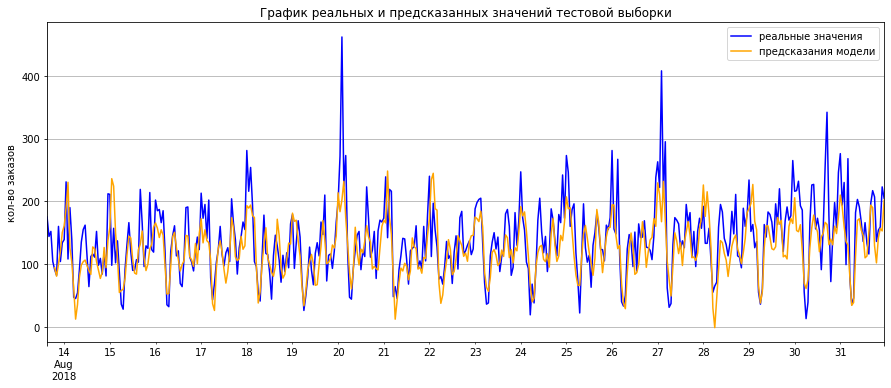

In [20]:
plt.figure(figsize=(15, 20))
plt.subplot(311)
target_test.plot(color='blue')
test_pred.plot(color='orange')
plt.legend(['реальные значения', 'предсказания модели'])
plt.title('График реальных и предсказанных значений тестовой выборки')
plt.xlabel('')
plt.ylabel('кол-во заказов')
plt.grid()
plt.show()

Проведём тестирование на адекватность модели.

In [21]:
# Предскажем значения тестовой выборки средним из обучающей
pred_median = np.array([target_train.mean()] * target_test.shape[0])
print('RMSE =', mean_squared_error(target_test, pred_median) ** .5)

RMSE = 87.73189133639056


In [22]:
# Предскажем каждое следующее значение предыдущим
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
print('RMSE =', mean_squared_error(target_test, pred_previous) ** .5)

RMSE = 58.977915848418455


Значение RMSE модели линейной регрессии ниже, чем в обоих тестах на адекватность, следовательно модель адекватная. Таргетное значение метрики RMSE ниже 48 достигнуто.

## Общий вывод
**Подготовка**  
Данные загружены, проверена хронология, проведено ресемплирование с интервалом 1 час.  

**Анализ**  
По линии тренда наблюдается рост заказов такси с течением времени.  
График сезонности стационарный, наблюдается зависимость количества заказов такси по часам.  
В августе наблюдаются единичные высокие значения заказов такси.  

**Обучение**  
Обучены модели линейной регрессии и случайный лес. Разница в качестве у моделей на валидационной выборке небольшая, но модель линейной регрессии обучается в несколько раз быстрее. Для тестирования выбрана модель линейной регрессии.  

**Тестирование**  
Вычислена метрика качества RMSE модели линейной регрессии на тестовых данных. Её показатель ниже 48, цель создания необходимой модели предсказания достигнута.  
Построен график с реальными и предсказанными значениями тестовой выборки. Модель чаще предсказывает количество заказов меньше, чем истинное значение.